In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xmltodict
import json
import datetime

In [43]:
from urllib.parse import urlparse
from collections import defaultdict

In [2]:
# !pip install validators
# !pip install statsmodels

In [3]:
# Two handy libraries for checking if a URL is valid or not
# import surt
import validators
import warnings
import glob

In [4]:
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

## SEC-Registered

In [6]:
df_sec = pd.read_csv(glob.glob('data/sec/IA_FIRM_SEC_Feed_*.csv')[0],
                     low_memory=False)

In [7]:
sorted(df_sec.columns.to_list())

['Filing.@Dt',
 'Filing.@FormVrsn',
 'FormInfo.Part1A.Item1.@Q1F5',
 'FormInfo.Part1A.Item1.@Q1I',
 'FormInfo.Part1A.Item1.@Q1M',
 'FormInfo.Part1A.Item1.@Q1N',
 'FormInfo.Part1A.Item1.@Q1O',
 'FormInfo.Part1A.Item1.@Q1ODesc',
 'FormInfo.Part1A.Item1.@Q1P',
 'FormInfo.Part1A.Item1.WebAddrs',
 'FormInfo.Part1A.Item1.WebAddrs.WebAddr',
 'FormInfo.Part1A.Item10A.@Q10A',
 'FormInfo.Part1A.Item11.@Q11',
 'FormInfo.Part1A.Item11A.@Q11A1',
 'FormInfo.Part1A.Item11A.@Q11A2',
 'FormInfo.Part1A.Item11B.@Q11B1',
 'FormInfo.Part1A.Item11B.@Q11B2',
 'FormInfo.Part1A.Item11C.@Q11C1',
 'FormInfo.Part1A.Item11C.@Q11C2',
 'FormInfo.Part1A.Item11C.@Q11C3',
 'FormInfo.Part1A.Item11C.@Q11C4',
 'FormInfo.Part1A.Item11C.@Q11C5',
 'FormInfo.Part1A.Item11D.@Q11D1',
 'FormInfo.Part1A.Item11D.@Q11D2',
 'FormInfo.Part1A.Item11D.@Q11D3',
 'FormInfo.Part1A.Item11D.@Q11D4',
 'FormInfo.Part1A.Item11D.@Q11D5',
 'FormInfo.Part1A.Item11E.@Q11E1',
 'FormInfo.Part1A.Item11E.@Q11E2',
 'FormInfo.Part1A.Item11E.@Q11E3',
 'F

In [8]:
sec_cols = set(df_sec.columns)

Number of Advisers

In [9]:
df_sec.shape[0]

21100

## State-Registered Advisers 

In [10]:
df_state = pd.read_csv(glob.glob('data/sec/IA_FIRM_STATE_Feed_*.csv')[0],
                     low_memory=False)

In [11]:
sorted(df_state.columns.to_list())

['ERA.Rgltrs',
 'ERA.Rgltrs.Rgltr',
 'ERA.Rgltrs.Rgltr.@Cd',
 'ERA.Rgltrs.Rgltr.@Dt',
 'ERA.Rgltrs.Rgltr.@St',
 'Filing.@Dt',
 'Filing.@FormVrsn',
 'FormInfo.Part1A.Item1.@Q1F5',
 'FormInfo.Part1A.Item1.@Q1I',
 'FormInfo.Part1A.Item1.@Q1M',
 'FormInfo.Part1A.Item1.@Q1N',
 'FormInfo.Part1A.Item1.@Q1O',
 'FormInfo.Part1A.Item1.@Q1ODESC',
 'FormInfo.Part1A.Item1.@Q1P',
 'FormInfo.Part1A.Item1.WebAddrs',
 'FormInfo.Part1A.Item1.WebAddrs.WebAddr',
 'FormInfo.Part1A.Item10A.@Q10A',
 'FormInfo.Part1A.Item11.@Q11',
 'FormInfo.Part1A.Item11A.@Q11A1',
 'FormInfo.Part1A.Item11A.@Q11A2',
 'FormInfo.Part1A.Item11B.@Q11B1',
 'FormInfo.Part1A.Item11B.@Q11B2',
 'FormInfo.Part1A.Item11C.@Q11C1',
 'FormInfo.Part1A.Item11C.@Q11C2',
 'FormInfo.Part1A.Item11C.@Q11C3',
 'FormInfo.Part1A.Item11C.@Q11C4',
 'FormInfo.Part1A.Item11C.@Q11C5',
 'FormInfo.Part1A.Item11D.@Q11D1',
 'FormInfo.Part1A.Item11D.@Q11D2',
 'FormInfo.Part1A.Item11D.@Q11D3',
 'FormInfo.Part1A.Item11D.@Q11D4',
 'FormInfo.Part1A.Item11D.@Q11D5

In [12]:
state_cols = set(df_state.columns)

Number of Advisers

In [13]:
df_state.shape[0]

21266

## Join SEC & State-Registered Advisers 

In [14]:
df_state_ids = df_state.loc[:,['Info.@BusNm',
                             'Info.@FirmCrdNb',
                             'Info.@LegalNm',
                             'Info.@SECNb']]

In [15]:
df_sec_ids = df_sec.loc[:,['Info.@BusNm',
                         'Info.@FirmCrdNb',
                         'Info.@LegalNm',
                         'Info.@SECNb']]

In [16]:
df_all_ids = pd.merge(df_state_ids, df_sec_ids,
                      how='outer',
                      # on=['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm'],
                      indicator=True)

In [17]:
df_state_cols = set(df_state.columns)
df_sec_cols = set(df_sec.columns)

In [18]:
print('There are %s unique columns in total' %len(df_sec_cols.union(df_state_cols)))
print('')
print('%s columns are in both State & SEC' %len(df_sec_cols.intersection(df_state_cols)))
print('')
print('%s columns are in only one of State or SEC' %len(df_sec_cols.symmetric_difference(df_state_cols)))
print('of which:')
print('%s columns are in only SEC' %len(df_sec_cols.difference(df_state_cols)))
print('%s columns are in only State' %len(df_state_cols.difference(df_sec_cols)))

There are 337 unique columns in total

255 columns are in both State & SEC

82 columns are in only one of State or SEC
of which:
23 columns are in only SEC
59 columns are in only State


In [19]:
### Clean up the data

In [20]:
# We'll process the data in 3 parts:
# 1. Firms in both (the hard part, as entries for common columns may not be the same across the 2 datasets)
# 2. Firms in State only
# 3. Firms in SEC only

In [21]:
df_both_ids = df_all_ids[df_all_ids._merge == 'both'].drop(columns=['_merge'])
df_state_only_ids = df_all_ids[df_all_ids._merge == 'left_only'].drop(columns=['_merge'])
df_sec_only_ids = df_all_ids[df_all_ids._merge == 'right_only'].drop(columns=['_merge'])

In [22]:
df_both_ids.shape[0]

1787

In [23]:
df_both_state_data = pd.merge(df_state, df_both_ids,
                              how = 'right',
                              on=['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm'])

In [24]:
df_both_sec_data = pd.merge(df_sec, df_both_ids,
                            how = 'right',
                            on=['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm'])

In [25]:
# this operation can cause a lot of "type mismatch" style errors
# TODO: specify dtype on the initial pd.read_csv methods & confirm this fixes the errors
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df_both = pd.merge(df_both_state_data, df_both_sec_data,
                       how='outer',
                       suffixes = ('__State', '__SEC'))

In [26]:
# We gained extra rows during merge -- so some data in the common columns did not match
df_both.shape[0]

1799

In [27]:
df_both_value_counts = df_both.value_counts(subset=['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm'])

In [28]:
df_both_mismatched_data_ids = df_both_value_counts[df_both_value_counts > 1].index.to_frame().reset_index(drop=True)

In [29]:
df_both_mismatched_data_ids.shape[0]

12

In [30]:
# Double check that this is all the "extra" rows
assert df_both_mismatched_data_ids.shape[0] == df_both.shape[0] - df_both_ids.shape[0]

In [31]:
merged_series = []
for row in df_both_mismatched_data_ids.iterrows():
    df_mismatch = df_both[(df_both['Info.@FirmCrdNb'] == row[1]['Info.@FirmCrdNb']) &\
                           (df_both['Info.@SECNb'] == row[1]['Info.@SECNb']) &\
                           (df_both['Info.@BusNm'] == row[1]['Info.@BusNm']) &\
                           (df_both['Info.@LegalNm'] == row[1]['Info.@LegalNm'])].copy()
    df_both.drop(index=df_mismatch.index, inplace=True)
    df_mismatch = df_mismatch.transpose()
    increasing_nulls_index = df_mismatch.isna().sum().sort_values(ascending=True).index
    best_merge = df_mismatch.loc[:,increasing_nulls_index[0]].combine_first(df_mismatch.loc[:,increasing_nulls_index[1]])
    merged_series.append(best_merge)

In [32]:
df_both_mismatched_data_fixed = pd.DataFrame(merged_series)

In [33]:
df_both = pd.concat([df_both, df_both_mismatched_data_fixed]).reset_index(drop=True)

In [34]:
df_both.head()

,Info.@FirmCrdNb,Info.@BusNm,Info.@LegalNm,Info.@UmbrRgstn,MainAddr.@Strt1,MainAddr.@Strt2,MainAddr.@City,MainAddr.@State,MainAddr.@Cntry,MainAddr.@PostlCd,...,FormInfo.Part1A.Item2A.@Q2A11,FormInfo.Part1A.Item2A.@Q2A12,FormInfo.Part1A.Item2A.@Q2A13,FormInfo.Part1A.Item1.@Q1ODesc,FormInfo.Part1A.Item2B.@Q2B1,FormInfo.Part1A.Item2B.@Q2B2,FormInfo.Part1A.Item2B.@Q2B3,NoticeFiled.States.@RgltrCd,NoticeFiled.States.@St,NoticeFiled.States.@Dt
0,171863,MOSAIK PARTNERS,"MOSAIK PARTNERS, LP",NaN,555 CALIFORNIA STREET,24TH FLOOR,SAN FRANCISCO,CA,United States,94104,...,NaN,NaN,NaN,NaN,Y,N,N,NaN,NaN,NaN
1,298061,ZZG CAPITAL LLC,ZZG CAPITAL LLC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Y,N,N,NaN,NaN,NaN
2,161098,OKAPI VENTURE CAPITAL,"OKAPI VENTURE CAPITAL, LLC",NaN,1600 NEWPORT CENTER DRIVE,SUITE 1600,NEWPORT BEACH,CA,United States,92660,...,NaN,NaN,NaN,NaN,Y,Y,N,NaN,NaN,NaN
3,298342,IDEO COLAB VENTURES LLC,IDEO COLAB VENTURES LLC,NaN,501 THE EMBARCADERO,PIER 28 ANNEX,SAN FRANCISCO,CA,United States,94105,...,NaN,NaN,NaN,NaN,Y,N,N,NaN,NaN,NaN
4,226615,"MEGHALAYA PARTNERS, L.P.","MEGHALAYA PARTNERS, L.P.",NaN,500 WEST PUTNAM AVENUE,SUITE 400,GREENWICH,CT,United States,06830,...,NaN,NaN,NaN,NaN,N,Y,N,NaN,NaN,NaN


In [35]:
df_only_state_data = pd.merge(df_state, df_state_only_ids,
                              how = 'right',
                              on=['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm'])

In [36]:
df_only_sec_data = pd.merge(df_sec, df_sec_only_ids,
                            how = 'right',
                            on=['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm'])

In [37]:
df_state_or_sec = pd.merge(df_only_state_data, df_only_sec_data,
                   how='outer',
                   suffixes = ('__State', '__SEC'))

In [38]:
assert df_state_or_sec.columns.str.endswith('__State').any() == False
assert df_state_or_sec.columns.str.endswith('__SEC').any() == False

In [39]:
df_all = pd.merge(df_state_or_sec, df_both,
                   how='outer',
                   suffixes = ('__State', '__SEC'))

In [40]:
assert df_all.shape[0] == df_all_ids.shape[0]

In [41]:
df_all

,Info.@FirmCrdNb,Info.@BusNm,Info.@LegalNm,Info.@UmbrRgstn,MainAddr.@Strt1,MainAddr.@Strt2,MainAddr.@City,MainAddr.@State,MainAddr.@Cntry,MainAddr.@PostlCd,...,FormInfo.Part1A.Item2A.@Q2A11,FormInfo.Part1A.Item2A.@Q2A12,FormInfo.Part1A.Item2A.@Q2A13,FormInfo.Part1A.Item1.@Q1ODesc,FormInfo.Part1A.Item2B.@Q2B1,FormInfo.Part1A.Item2B.@Q2B2,FormInfo.Part1A.Item2B.@Q2B3,NoticeFiled.States.@RgltrCd,NoticeFiled.States.@St,NoticeFiled.States.@Dt
0,146099,PRINCIPA FINANCIAL ADVISORS,"CHUNG, BUCK CHWEE",N,15111 WHITTIER BLVD,STE 360,WHITTIER,CA,United States,90603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,289221,HOMEWOOD CAPITAL MANAGEMENT EAST LLC,HOMEWOOD CAPITAL MANAGEMENT EAST LLC,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23940,"OFG FINANCIAL SERVICES, INC.","OFG FINANCIAL SERVICES, INC.",N,120 SE 6TH AVENUE,"TOWNSITE PLAZA #2, SUITE 105",TOPEKA,KS,United States,66603-3515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,155220,WORCH CAPITAL LLC,WORCH CAPITAL LLC,N,11300 ROCKVILLE PIKE,NaN,ROCKVILLE,MD,United States,20852,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,122779,"FINANCIAL PLANNING RESOURCES,LLC","FINANCIAL PLANNING RESOURCES,LLC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40574,298150,COMPOUND INSIGHT,"COMPOUND INSIGHT, LLC",N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,N,Y,N,NaN,NaN,NaN
40575,306263,ASTRA VENTURES,ASTRA VENTURES INVESTMENT PARTNERS LLC,N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,N,Y,N,NaN,NaN,NaN
40576,169199,"SHEROW MANAGEMENT, LLC","SHEROW MANAGEMENT, LLC",N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,N,Y,N,NaN,NaN,NaN
40577,154538,"SALT MARSH INVESTMENTS, LLC","SALT MARSH INVESTMENTS, LLC",N,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,N,Y,N,NaN,NaN,NaN


# Get All Web Addresses

In [44]:
def parse_array(web_addr):
    if web_addr in (None, np.NaN):
        return np.NaN
    web_addr = web_addr.lower()
    # @quantology
    if web_addr.startswith("["):
        web_addr = web_addr.replace("'", '"')
        web_addr = web_addr.removeprefix("[").removesuffix("]")
        candidates = [url.removeprefix('"').removesuffix('"') for url in web_addr.split(", ")]
    else:
        candidates = [web_addr]
    return candidates

In [45]:
df_all['urls'] = df_all['FormInfo.Part1A.Item1.WebAddrs.WebAddr'].apply(parse_array)

In [46]:
df_all['urls']

0                                                      NaN
1                                                      NaN
2                            [http://www.ofgfinancial.com]
3        [https://www.worchcapital.com/, https://www.li...
4                                                      NaN
                               ...                        
40574    [https://www.scuttleblurb.com, http://www.comp...
40575    [https://www.linkedin.com/company/64656852/adm...
40576                   [https://www.sherowmanagement.com]
40577                                                  NaN
40578                                                  NaN
Name: urls, Length: 40579, dtype: object

In [47]:
# @quantology
def parse_urls(urls):
    if not isinstance(urls, list):
        return np.NaN, np.NaN
    domains = []
    schemes = []
    for url in urls:
        if validators.url(url):
            parsed_url = urlparse(url)
            domain = parsed_url.netloc
            if domain.startswith("www."):
                domain = domain.removeprefix("www.")
            elif domain.startswith("m."):
                domain = domain.removeprefix("m.")
            elif domain.startswith("mobile."):
                domain = domain.removeprefix("mobile.")
            domains.append(domain)
            schemes.append(parsed_url.scheme)
    return domains, schemes

In [48]:
# TODO: make less fugly
df_all_urls = df_all.apply(lambda x: parse_urls(x['urls']), axis=1, result_type='expand')
df_all_urls.columns = ['url_domains', 'url_schemes']

In [49]:
df_all = df_all.join(df_all_urls)

In [50]:
df_all[['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm', 'urls','url_domains', 'url_schemes']].head()

,Info.@FirmCrdNb,Info.@SECNb,Info.@BusNm,Info.@LegalNm,urls,url_domains,url_schemes
0,146099,NaN,PRINCIPA FINANCIAL ADVISORS,"CHUNG, BUCK CHWEE",NaN,NaN,NaN
1,289221,NaN,HOMEWOOD CAPITAL MANAGEMENT EAST LLC,HOMEWOOD CAPITAL MANAGEMENT EAST LLC,NaN,NaN,NaN
2,23940,NaN,"OFG FINANCIAL SERVICES, INC.","OFG FINANCIAL SERVICES, INC.",[http://www.ofgfinancial.com],[ofgfinancial.com],[http]
3,155220,NaN,WORCH CAPITAL LLC,WORCH CAPITAL LLC,"[https://www.worchcapital.com/, https://www.li...","[worchcapital.com, linkedin.com, worchcapital....","[https, https, http, https]"
4,122779,NaN,"FINANCIAL PLANNING RESOURCES,LLC","FINANCIAL PLANNING RESOURCES,LLC",NaN,NaN,NaN


In [51]:
SOCIAL_MEDIA = [
    'linkedin.com',
    'facebook.com',
    'twitter.com',
    'instagram.com',
    'youtube.com',
    'vimeo.com',
    'medium.com',
    'tiktok.com',
    'pinterest.com',
    'soundcloud.com',
    'plus.google.com',
    'open.spotify.com',
    'reddit.com',
    'linkedin',
    'podcasts.apple.com',
    'seekingalpha.com',
    'apple.co', #TODO: Prcessing error? #podcasts.apple.com
    'apple.com',
    'glassdoor.com',
    'spoti.fi',
    'ca.linkedin.com',
    'business.facebook.com',
    'mp.weixin.qq.com', #wechat
    'hvst.com',
    'douyin.com', #tiktok in chinese
    'anchor.fm', #podcasts
    'line.naver.jp', #chinese wechat competitor, only Blackrock is on it!
    'hk.linkedin.com', 
    'quora.com', 
    'slideshare.net', #sharing ppt's!
    'g.page',  #google business page
    'sg.linkedin.com',
    'au.linkedin.com',  
    'stitcher.com', # podcasts
    'itunes.apple.com', # podcasts
    'instragram.com', #typo, but it still redirects
    'podcasts.google.com',   
    'uk.linkedin.com', 
    'facebook', #TODO: Prcessing error?
    'buzzsprout.com', #podcast
    'ja-jp.facebook.com', 
    'stocktwits.com',
    'blog.naver.com', #chinese wechat competitor only AB on this!
]

In [52]:
AGGREGATOR_SITES = [
    'yelp.com',
    'angel.co',
    'feeonlynetwork.com',
    'crunchbase.com',
    'thefinancialhq.com', #this is a weird one - no "homepage" to speak of
    'napfa.org',
    'alignable.com',
    'realwealthmedia.com',
    'letsmakeaplan.org' # CFP official site (for clients)
    'google.com', # Typically google maps
    'nextdoor.com',
    'xyplanningnetwork.com',
    'plannersearch.org', # FPA official website
]

In [53]:
LINKEDIN_SITES = [
                    'linkedin.com',
                    'linkedin',
                    'ca.linkedin.com',
                    'hk.linkedin.com', 
                    'sg.linkedin.com',
                    'au.linkedin.com', 
                    'uk.linkedin.com', 
]

In [54]:
processing_errors = [
    'apple.co',
    'link.edgepilot.com',
    'facebook',
]

In [55]:
def isin_group(x, group_list, return_bool=True, handle_nulls = True, inverse=False):
    if handle_nulls and isinstance(x, float): # np.NaN is of type float!
        if np.isnan(x): # but the floats actually have to be eaual to nan
            if return_bool:
                return False
            return np.NaN
    if return_bool:
        if inverse:
            return any([(el not in group_list) for el in x if el is not None])
        return any([(el in group_list) for el in x if el is not None])
    else:
        if inverse:
            return [el for el in x if (el not in group_list) and (el is not None)]
        return [el for el in x if (el in group_list) and (el is not None)]

In [56]:
df_all['url_has_linkedin'] = df_all['url_domains'].apply(isin_group, group_list=LINKEDIN_SITES)
df_all['url_has_social_media'] = df_all['url_domains'].apply(isin_group, group_list=SOCIAL_MEDIA)
df_all['url_has_aggregator'] = df_all['url_domains'].apply(isin_group, group_list=AGGREGATOR_SITES)
df_all['url_has_firm_specific'] = df_all['url_domains'].apply(isin_group, group_list=SOCIAL_MEDIA + AGGREGATOR_SITES, inverse=True)

df_all['url_social_media'] = df_all['url_domains'].apply(isin_group, group_list=SOCIAL_MEDIA, return_bool=False)
df_all['url_aggregator'] = df_all['url_domains'].apply(isin_group, group_list=AGGREGATOR_SITES, return_bool=False)
df_all['url_firm_specific'] = df_all['url_domains'].apply(isin_group, group_list=SOCIAL_MEDIA + AGGREGATOR_SITES, inverse=True, return_bool=False)

In [57]:
df_all['url_social_media_count'] = df_all['url_social_media'].apply(lambda x: len(set(x)) if isinstance(x, list) else 0)

In [58]:
df_all['url_social_media_count'].max()

11

# Summarize Firm Assets Under Management (AUM) values

In [59]:
df_all['TotalAUM'] = df_all.loc[:,(df_all.columns.str.startswith('FormInfo.Part1A.Item5D') \
                                   & df_all.columns.str.endswith('3'))           
                               ].sum(axis=1)

# Firms by Registration Type

In [60]:
df_both_ids['registration'] = 'both'
df_state_only_ids['registration'] = 'state'
df_sec_only_ids['registration'] = 'sec'

In [61]:
df_registration = pd.concat([df_both_ids, df_state_only_ids, df_sec_only_ids])

In [62]:
df_all = df_all.merge(df_registration, how='left')

In [63]:
## Identify ERAs (so we can ignore them)

In [65]:
df_era_ids = df_all.loc[(df_all['ERA.Rgltrs'].notnull() |
                         df_all['ERA.Rgltrs.Rgltr'].notnull() |
                         df_all['ERA.Rgltrs.Rgltr.@Cd'].notnull() |
                         df_all['ERA.Rgltrs.Rgltr.@Dt'].notnull() |
                         df_all['ERA.Rgltrs.Rgltr.@St'].notnull() |
                         ( df_all['Rgstn.@FirmType'] == 'ERA' ) ),
                        'Info.@FirmCrdNb']

df_all.loc[df_era_ids.index, 'ERA'] = True
df_all['ERA'] = df_all['ERA'].fillna(False)

In [66]:
df_era_ids.shape[0]

8049

In [67]:
# recode zero employees
df_all['TotalEmp'] = np.where(df_all['FormInfo.Part1A.Item5A.@TtlEmp'] > 0, df_all['FormInfo.Part1A.Item5A.@TtlEmp'], 1)

In [68]:
df_ria = df_all[df_all['ERA'] == False].copy()

In [69]:
df_ria.shape

(32530, 352)

# Save to CSV

In [70]:
df_all.to_csv('data/clean/ALL_03_20_2023.csv', index=False)
df_ria.to_csv('data/clean/RIA_03_20_2023.csv', index=False)

# Questions:

- How many RIAs are in the full data set?


In [71]:
print(f'{df_ria.shape[0]:,} RIAs in the dataset')

32,530 RIAs in the dataset


- What RIAs do and don't have a website?

In [72]:
{'FormInfo.Part1A.Item1.@Q1I' : 'Do you have one or more websites (Y/N/null)'}
do_you_have_a_website_crosstab = pd.crosstab(df_ria['FormInfo.Part1A.Item1.@Q1I'],df_ria['url_has_firm_specific'])
do_you_have_a_website_crosstab

url_has_firm_specific,False,True
FormInfo.Part1A.Item1.@Q1I,,
N,6501,0
Y,535,25494


In [73]:
print(f"{df_ria['url_has_firm_specific'].sum():,} RIAs in the dataset have a website")
print(f"{df_ria['url_has_firm_specific'].sum()/df_ria.shape[0]:.1%} of the total")

25,494 RIAs in the dataset have a website
78.4% of the total


- Is it mainly independent IARs that don't?

In [74]:
df_ria_state = df_ria[df_ria['registration'] == 'state']
df_ria_sec = df_ria[df_ria['registration'] == 'sec']
df_ria_both = df_ria[df_ria['registration'] == 'both']
df_ria_notboth = df_ria[df_ria['registration'] != 'both']

In [75]:
print(f"{df_ria_state['url_has_firm_specific'].sum():,} state RIAs in the dataset have a website")
print(f"{df_ria_state['url_has_firm_specific'].sum()/df_ria_state.shape[0]:.1%} of the total")
print(f"{df_ria_sec['url_has_firm_specific'].sum():,} SEC RIAs in the dataset have a website")
print(f"{df_ria_sec['url_has_firm_specific'].sum()/df_ria_sec.shape[0]:.1%} of the total")
print(f"{df_ria_both['url_has_firm_specific'].sum():,} ambiguously-registered  RIAs in the dataset have a website")
print(f"{df_ria_both['url_has_firm_specific'].sum()/df_ria_both.shape[0]:.1%} of the total")

11,698 state RIAs in the dataset have a website
68.2% of the total
13,652 SEC RIAs in the dataset have a website
89.7% of the total
144 ambiguously-registered  RIAs in the dataset have a website
85.2% of the total


In [76]:
registration_crosstab = pd.crosstab(df_ria_notboth['registration'],df_ria_notboth['url_has_firm_specific'], normalize='index')
registration_crosstab.columns = ['No Website (%)', 'Has Website (%)']
registration_crosstab.round(2+2)*100

,No Website (%),Has Website (%)
registration,,
sec,10.28,89.72
state,31.77,68.23


<AxesSubplot:xlabel='FormInfo.Part1A.Item5A.@TtlEmp', ylabel='url_has_firm_specific'>

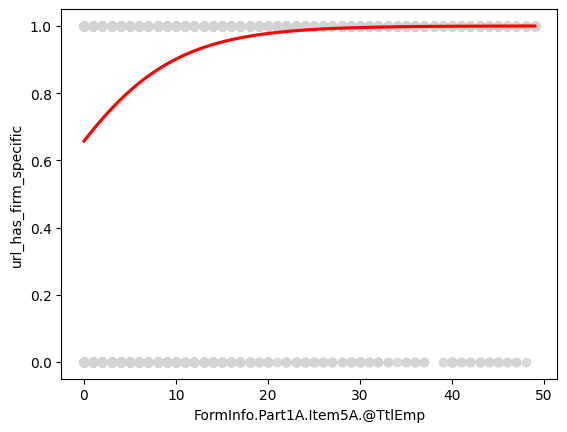

In [77]:
sns.regplot(x=df_ria[df_ria['FormInfo.Part1A.Item5A.@TtlEmp'] < 50]['FormInfo.Part1A.Item5A.@TtlEmp'],
            y=df_ria[df_ria['FormInfo.Part1A.Item5A.@TtlEmp'] < 50]['url_has_firm_specific'],
            data=df_ria[df_ria['FormInfo.Part1A.Item5A.@TtlEmp'] < 50],
            logistic=True,
            ci=None,
            scatter_kws={'color': 'lightgrey'},
            line_kws={'color': 'red'})

A simple logit model (x-axis = Total # of employees vs. y-axis = Probability Firm has a website) shows that average probability does increase with firm size.

However, there are many examples of firms which do & don't have websites at all sizes.

There are 15 firms with more than 200 employees which don't have a website:

In [78]:
df_ria.loc[(df_ria['FormInfo.Part1A.Item5A.@TtlEmp'] > 200) & (df_ria['url_has_firm_specific'] == False),
           ['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm', 'urls', 'TotalAUM', 'ERA']]

,Info.@FirmCrdNb,Info.@SECNb,Info.@BusNm,Info.@LegalNm,urls,TotalAUM,ERA
20040,159035,801-72795,"SCHWAB WEALTH ADVISORY, INC.","SCHWAB WEALTH ADVISORY, INC.",NaN,0.000000e+00,False
20445,142373,801-52664,"NATIONWIDE INVESTMENT ADVISORS, LLC","NATIONWIDE INVESTMENT ADVISORS, LLC",NaN,1.351000e+10,False
22352,109524,801-68510,"ALLSTATE FINANCIAL ADVISORS, LLC","ALLSTATE FINANCIAL ADVISORS, LLC",NaN,3.111972e+07,False
24435,281337,801-107176,BMO NESBITT BURNS SECURITIES LTD.,BMO NESBITT BURNS SECURITIES LTD.,NaN,5.542239e+08,False
25725,288841,801-111061,GOLDENTREE ASSET MANAGEMENT CREDIT ADVISOR LLC,GOLDENTREE ASSET MANAGEMENT CREDIT ADVISOR LLC,NaN,5.424637e+08,False
26935,154149,801-71541,VISION2020 WEALTH MANAGEMENT CORP.,VISION2020 WEALTH MANAGEMENT CORP.,NaN,2.111892e+10,False
27983,164593,801-76825,"VANGUARD GLOBAL ADVISERS, LLC","VANGUARD GLOBAL ADVISERS, LLC",NaN,3.952045e+11,False
28438,285820,801-108694,"MIDCAP FINANCIAL SERVICES CAPITAL MANAGEMENT, LLC","MIDCAP FINANCIAL SERVICES CAPITAL MANAGEMENT, LLC",NaN,5.807912e+09,False
29262,105193,801-29922,HSBC GLOBAL ASSET MANAGEMENT (HONG KONG) LIMITED,HSBC GLOBAL ASSET MANAGEMENT (HONG KONG) LIMITED,NaN,1.089447e+11,False
30287,106544,801-10787,NORTHWEST ADMINISTRATORS INC,NORTHWEST ADMINISTRATORS INC,[http://www.linkedin.com],4.611478e+08,False


- Is there any geographic observations around those that dont?

In [79]:
states_crosstab = pd.crosstab(df_ria['MainAddr.@State'],df_ria['url_has_firm_specific'], normalize='index').round(2+2)*100
states_crosstab.columns = ['No Website (%)', 'Has Website (%)']
states_crosstab.sort_values('No Website (%)', ascending=False)

,No Website (%),Has Website (%)
MainAddr.@State,,
ND,35.71,64.29
HI,30.00,70.00
PR,28.57,71.43
WY,25.00,75.00
WV,25.00,75.00
NM,22.45,77.55
AK,21.05,78.95
MT,20.83,79.17
RI,20.69,79.31


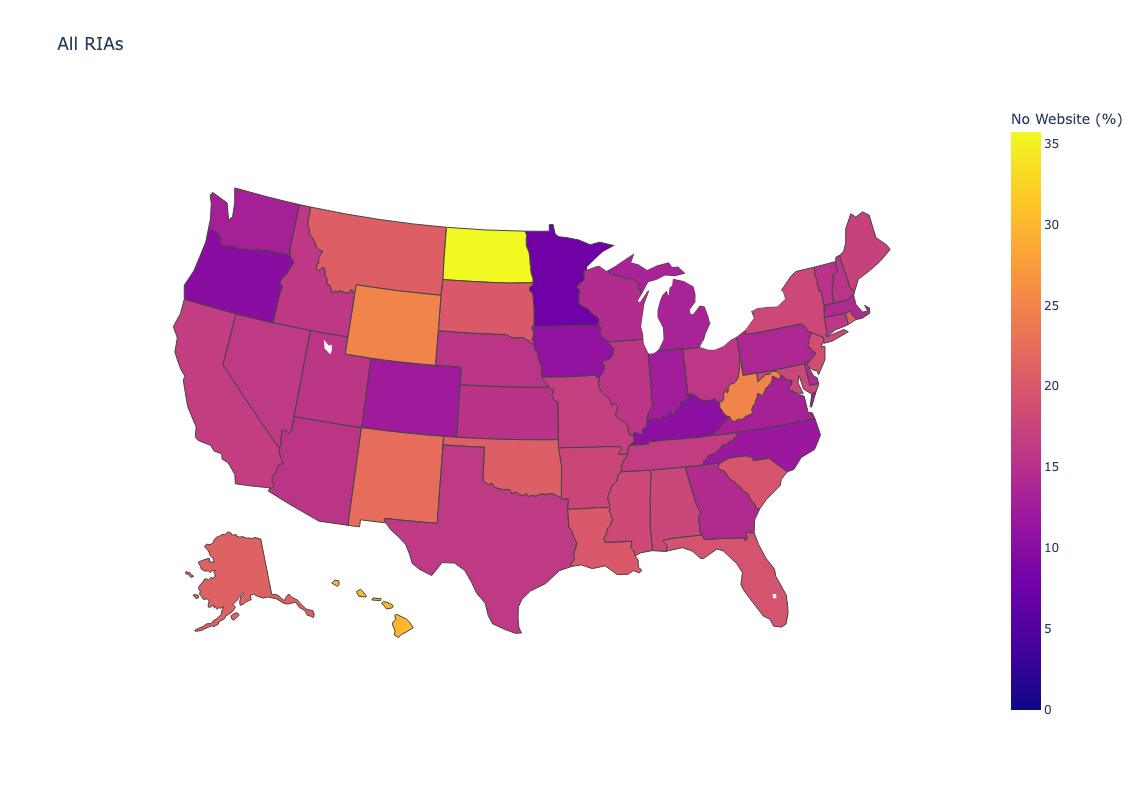

In [80]:
fig = px.choropleth(states_crosstab.reset_index(), 
                                locations='MainAddr.@State', 
                                locationmode='USA-states', 
                                color='No Website (%)',
                                scope='usa',
                    width = 1200,
                    height = 800,
                    title='All RIAs')
fig.show()

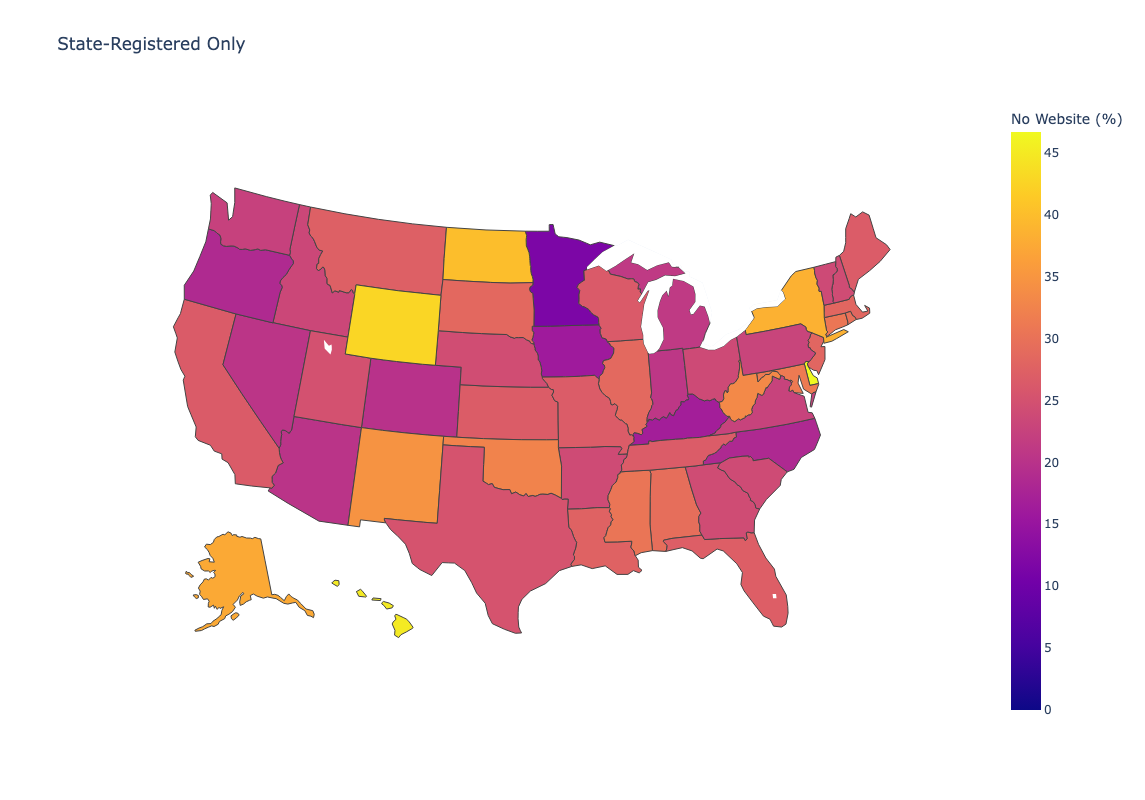

In [81]:
states_statereg_crosstab = pd.crosstab(df_ria[df_ria['registration'] == 'state']['MainAddr.@State'],
                                       df_ria[df_ria['registration'] == 'state']['url_has_firm_specific'],
                                       normalize='index').round(2+2)*100
states_statereg_crosstab.columns = ['No Website (%)', 'Has Website (%)']
fig = px.choropleth(states_statereg_crosstab.reset_index(), 
                    locations='MainAddr.@State', 
                    locationmode='USA-states', 
                    color='No Website (%)',
                    scope='usa',
                    width = 1200,
                    height = 800,
                   title='State-Registered Only')
fig.show()

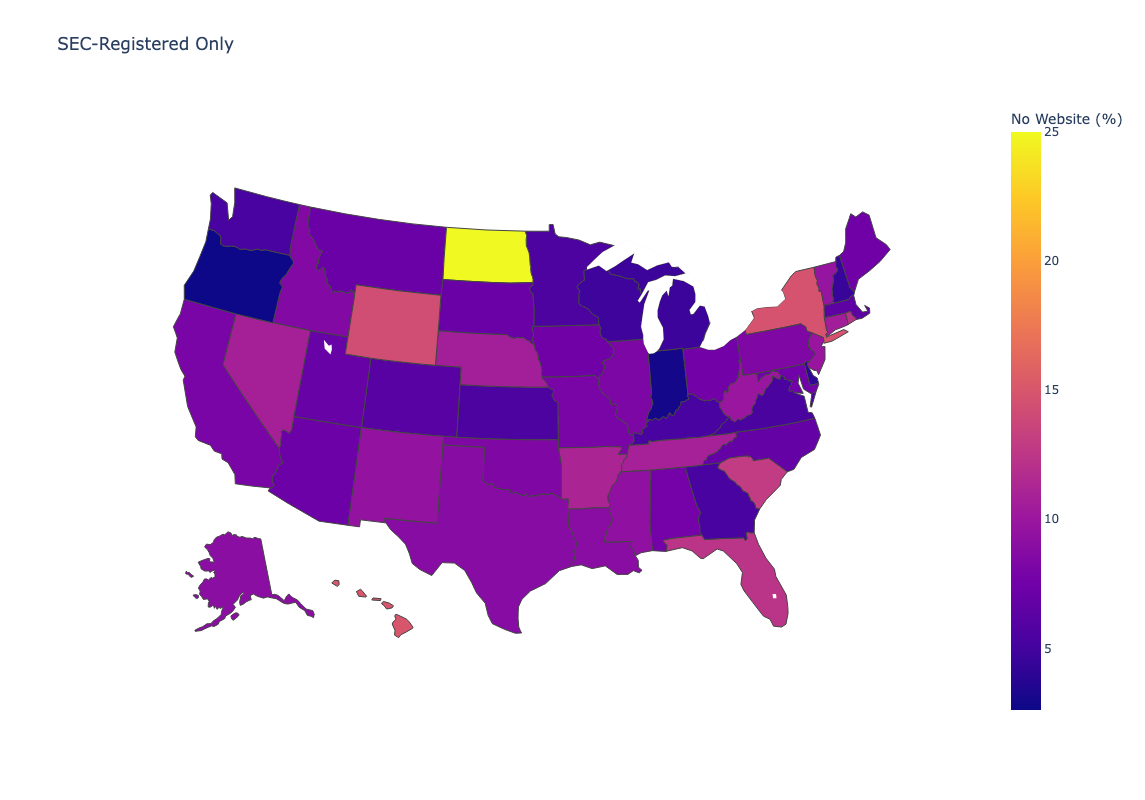

In [82]:
states_secreg_crosstab = pd.crosstab(df_ria[df_ria['registration'] == 'sec']['MainAddr.@State'],
                                       df_ria[df_ria['registration'] == 'sec']['url_has_firm_specific'],
                                       normalize='index').round(2+2)*100
states_secreg_crosstab.columns = ['No Website (%)', 'Has Website (%)']
fig = px.choropleth(states_secreg_crosstab.reset_index(), 
                    locations='MainAddr.@State', 
                    locationmode='USA-states', 
                    color='No Website (%)',
                    scope='usa',
                    width = 1200,
                    height = 800,
                   title='SEC-Registered Only')
fig.show()

- Is there an AUM mark that divides those that have a website and those that dont.

<AxesSubplot:xlabel='TotalAUM', ylabel='url_has_firm_specific'>

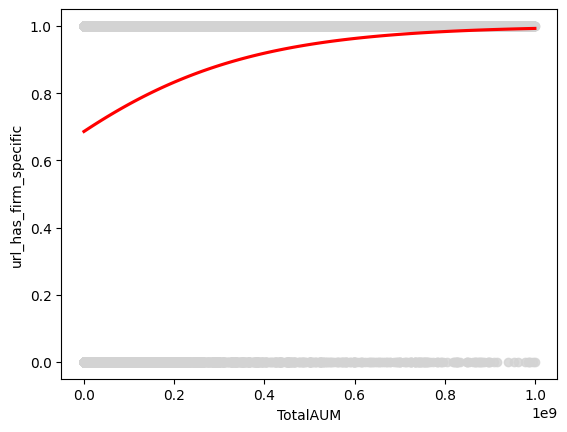

In [83]:
sns.regplot(x=df_ria[df_ria['TotalAUM'] < 1e9]['TotalAUM'],
            y=df_ria[df_ria['TotalAUM'] < 1e9]['url_has_firm_specific'],
            data=df_ria[df_ria['TotalAUM'] < 1e9],
            logistic=True,
            ci=None,
            scatter_kws={'color': 'lightgrey'},
            line_kws={'color': 'red'})

A simple logit model (x-axis = Total AUM in US$ bil vs. y-axis = Probability Firm has a website) shows that average probability does increase with AUM (red line).

However, there are many examples of firms which do & don't have websites at all AUMs (grey dots).

There are 319 firms with AUM > US$ 1bn which don't have a website:

In [84]:
df_ria.loc[(df_ria['TotalAUM'] > 1e9) & (df_ria['url_has_firm_specific'] == False),
           ['Info.@FirmCrdNb', 'Info.@SECNb', 'Info.@BusNm', 'Info.@LegalNm', 'urls', 'TotalAUM', 'ERA']]

,Info.@FirmCrdNb,Info.@SECNb,Info.@BusNm,Info.@LegalNm,urls,TotalAUM,ERA
3667,122988,NaN,"RANDY L. COPUS AND ASSOCIATES,LLC",RANDY L. COPUS & ASSOCIATES LLC.,NaN,3.300000e+09,False
19479,133693,801-73527,H/2 CAPITAL PARTNERS,H/2 CREDIT MANAGER LP,NaN,5.663254e+09,False
19497,135130,801-64204,EMERALD MUTUAL FUND ADVISERS TRUST,EMERALD MUTUAL FUND ADVISERS TRUST,NaN,2.916842e+09,False
19522,157907,801-73464,PRESCOTT GENERAL PARTNERS LLC,PRESCOTT GENERAL PARTNERS LLC,NaN,1.483399e+09,False
19593,299961,801-115011,"THIRD LAKE PARTNERS, LLC","THIRD LAKE PARTNERS, LLC",[https://www.linkedin.com/company/thirdlake],1.025194e+09,False
...,...,...,...,...,...,...,...
38303,322923,801-126520,26 NORTH,26NORTH PARTNERS LP,NaN,5.309865e+09,False
38316,321109,801-125868,"SAMMONS FINANCIAL GROUP ASSET MANAGEMENT, LLC","SAMMONS FINANCIAL GROUP ASSET MANAGEMENT, LLC",NaN,5.763204e+09,False
38581,323495,801-126789,REGIS ACQUISITION INC.,REGIS ACQUISITION INC.,NaN,1.511075e+09,False
38658,318983,801-124970,"MSR CAPITAL PARTNERS, LLC","MSR CAPITAL PARTNERS, LLC",NaN,2.693290e+09,False


<AxesSubplot:xlabel='TotalAUM_per_Employee', ylabel='url_has_firm_specific'>

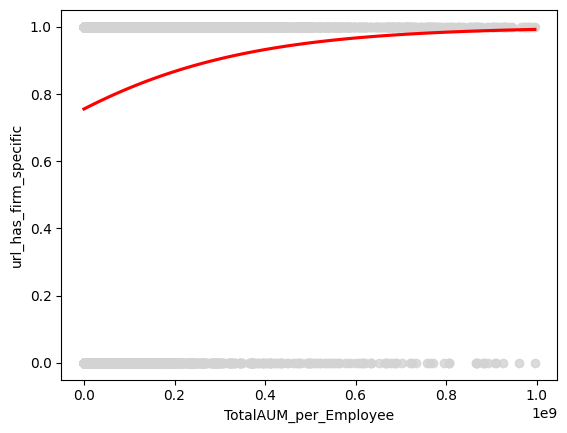

In [85]:
df_ria['TotalAUM_per_Employee'] = df_ria['TotalAUM']/df_ria['TotalEmp']
sns.regplot(x=df_ria[df_ria['TotalAUM_per_Employee'] < 1e9]['TotalAUM_per_Employee'],
            y=df_ria[df_ria['TotalAUM_per_Employee'] < 1e9]['url_has_firm_specific'],
            data=df_ria[df_ria['TotalAUM_per_Employee'] < 1e9],
            logistic=True,
            ci=None,
            scatter_kws={'color': 'lightgrey'},
            line_kws={'color': 'red'})

- Is there an age mark that divides those that have a website and those that don't.

 Can't tell with this dataset. Maybe with the IAR dataset + linkedin. Not worth doing it at this point

- How many RIAs just have a linkedin account?

In [86]:
print(f"State RIAs: {df_ria_state[(df_ria_state['url_has_firm_specific'] == False) & (df_ria_state['url_has_linkedin'] == True)].shape[0]}")

State RIAs: 286


In [87]:
print(f"SEC RIAs: {df_ria_sec[(df_ria_sec['url_has_firm_specific'] == False) & (df_ria_sec['url_has_linkedin'] == True)].shape[0]}")

SEC RIAs: 106


Cross-tabulate with firm counts

In [88]:
pd.crosstab(columns = df_ria_notboth['url_has_linkedin'],
            index = [df_ria_notboth['registration'], df_ria_notboth['url_has_firm_specific']],
            margins=True,
            rownames=['registration','website'],
            colnames=['linkedin'])

linkedin              False   True    All
registration website                     
sec          False     1459    106   1565
             True      5671   7981  13652
state        False     5160    286   5446
             True      7555   4143  11698
All                   19845  12516  32361

Cross-tabulate with firm percentages of total (across rows)

In [89]:
pd.crosstab(columns = df_ria_notboth['url_has_linkedin'],
            index = [df_ria_notboth['registration'], df_ria_notboth['url_has_firm_specific']],
            margins=True,
            normalize='index',
            rownames=['registration','website'],
            colnames=['linkedin']).round(2+2)*100

linkedin              False   True
registration website              
sec          False    93.23   6.77
             True     41.54  58.46
state        False    94.75   5.25
             True     64.58  35.42
All                   61.32  38.68

- Have many social media accounts do majority of RIAs have? Linkedin, facebook, twitter, other?

<AxesSubplot:>

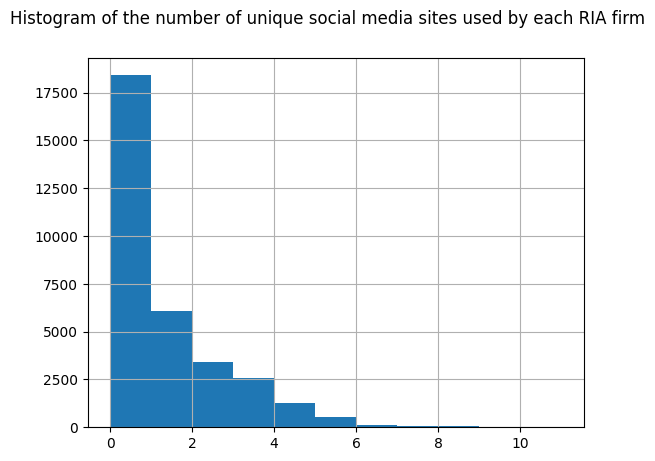

In [90]:
fig, axes = plt.subplots()
plt.suptitle('Histogram of the number of unique social media sites used by each RIA firm')
df_ria['url_social_media_count'].hist(bins = range(0, 12), ax=axes)

<AxesSubplot:title={'center':'SEC RIAs'}>

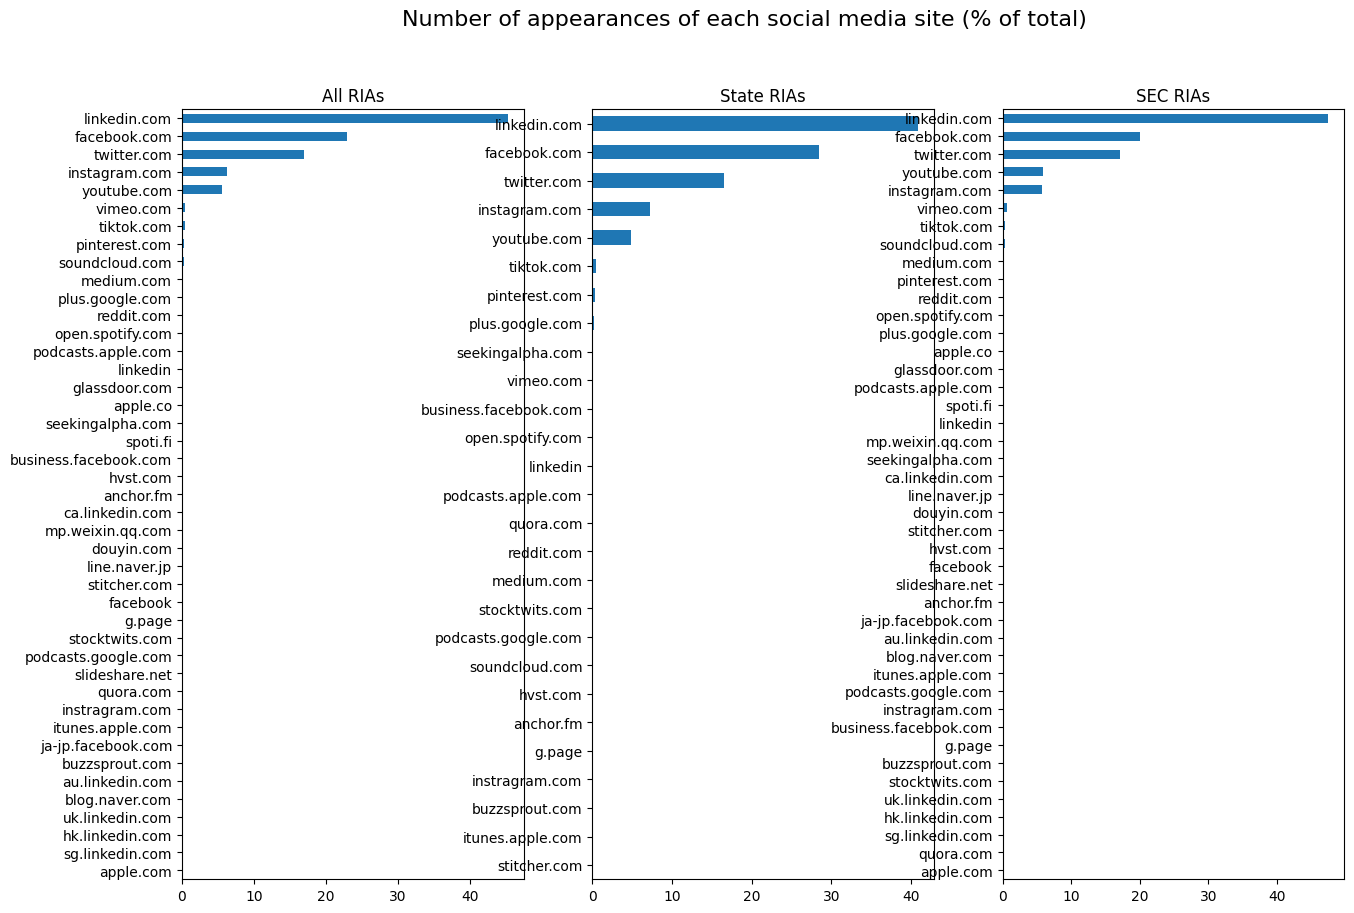

In [91]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize = (15,10))
fig.suptitle('Number of appearances of each social media site (% of total)',
             fontsize=16)

(df_ria['url_social_media'].explode()\
 .value_counts(normalize=True, ascending=True)*100)\
 .plot.barh(title='All RIAs',
            ax=axes[0])
(df_ria_state['url_social_media'].explode()\
 .value_counts(normalize=True, ascending=True)*100)\
 .plot.barh(title='State RIAs',
            ax=axes[1])
(df_ria_sec['url_social_media'].explode()\
 .value_counts(normalize=True, ascending=True)*100)\
 .plot.barh(title='SEC RIAs',
            ax=axes[2])

- For those with websites, how many are http vs https --- or is there some way to identify the ages of them?

All RIAs

In [92]:
df_ria['url_schemes'].explode().value_counts(normalize=True).round(2+2)*100

https    69.85
http     30.15
Name: url_schemes, dtype: float64

State RIAs

In [93]:
df_ria_state['url_schemes'].explode().value_counts(normalize=True).round(2+2)*100

https    65.15
http     34.85
Name: url_schemes, dtype: float64

SEC RIAs

In [94]:
df_ria_sec['url_schemes'].explode().value_counts(normalize=True).round(2+2)*100

https    72.32
http     27.68
Name: url_schemes, dtype: float64

Internet average is 81.9% using HTTPS (https://w3techs.com/technologies/history_overview/site_element/all), so RIAs are definitely behind the curve!

Maybe use https://websiteage.org/ but you would have to pay

## Years since firm formation
If you are organized other than as a sole proprietorship, please provide the following:
(1)	Indicate the date you obtained your legal status. Date of formation: 

In [96]:
df_ria['FormInfo.Part1B.ItemK.@Q1B2K1'] = pd.to_datetime(df_ria['FormInfo.Part1B.ItemK.@Q1B2K1'])
df_ria['Years_since_formation'] = df_ria['FormInfo.Part1B.ItemK.@Q1B2K1'].apply(lambda x: (datetime.datetime.now() - x).days/365)

<AxesSubplot:>

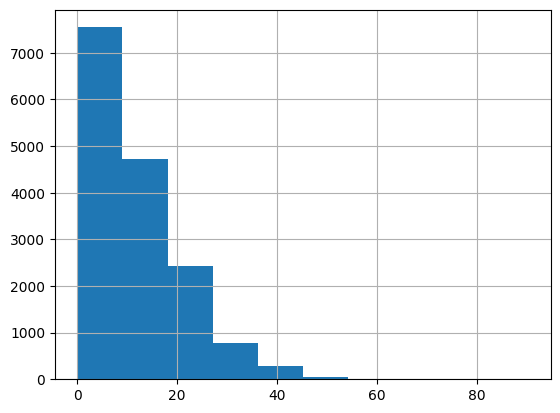

In [97]:
df_ria['Years_since_formation'].hist()